In [1]:
%matplotlib inline

# 大藝術家(cntk)

![style transfer](../Images/styletransfer.png)

In [2]:
from __future__ import print_function
import numpy as np
from scipy import optimize as opt
import cntk as C
from cntk.device import *
from PIL import Image
import os
import matplotlib.pyplot as plt
import _pickle as pickle


is_gpu = False
if is_gpu:
    try_set_default_device(gpu(0))
else:
    try_set_default_device(cpu())

In [3]:
layers=None
with open('../Data/VGG16_layers.pkl', 'rb') as fp:
    layers=pickle.load(fp)
    
def vggblock(x, arrays, layer_map, name):
    f = arrays[0]
    b = arrays[1]
    k = C.constant(value=f)
    t = C.constant(value=np.reshape(b, (-1, 1, 1)))
    y = C.relu(C.convolution(k, x, auto_padding=[False, True, True]) + t)
    layer_map[name] = y
    return y

# VGG network中的池化層
def vggpool(x):
    return C.pooling(x, C.AVG_POOLING, (2, 2), (2, 2))


# 建構vgg16排除最後的全連接層
def model(x, layers):
    model_layers = {}
    def convolutional(z): return len(z) == 2 and len(z[0].shape) == 4
    conv = [layer for layer in layers if convolutional(layer)]
    cnt = 0
    num_convs = {1: 2, 2: 2, 3: 3, 4: 3, 5: 3}
    for outer in range(1,6):
        for inner in range(num_convs[outer]):
            x = vggblock(x, conv[cnt], model_layers, 'conv%d_%d' % (outer, 1+inner))
            cnt += 1
        x = vggpool(x)
    
    return x, C.combine([model_layers[k] for k in sorted(model_layers.keys())])


# #內容損失

In [4]:
def content_loss(a,b):
    channels, x, y = a.shape
    return C.squared_error(a, b)/(channels*x*y)

# #風格損失

In [5]:
def flatten(x):
    assert len(x.shape) >= 3
    return C.reshape(x, (x.shape[-3], x.shape[-2] * x.shape[-1]))

#這個是給cntk變數用的gram矩陣
def gram(x):
    features = C.minus(flatten(x), C.reduce_mean(x))
    return C.times_transpose(features, features)

#這個是給numpy array用的gram矩陣
def npgram(x):
    features = np.reshape(x, (-1, x.shape[-2]*x.shape[-1])) - np.mean(x)
    return features.dot(features.T)


def style_loss(a, b):
    channels, x, y = a.shape
    #assert x == y
    A = gram(a)
    B = npgram(b)
    return C.squared_error(A, B)/(channels**2 * x**2 * y**2)



# #總體變動損失

In [6]:
def total_variation_loss(x):
    xx = C.reshape(x, (1,)+x.shape)
    delta = np.array([-1, 1], dtype=np.float32)
    kh = C.constant(value=delta.reshape(1, 1, 1, 1, 2))
    kv = C.constant(value=delta.reshape(1, 1, 1, 2, 1))
    dh = C.convolution(kh, xx, auto_padding=[False])
    dv = C.convolution(kv, xx, auto_padding=[False])
    avg = 0.5 * (C.reduce_mean(C.square(dv)) + C.reduce_mean(C.square(dh)))
    return avg

![style all](../Images/style_all.jpg)

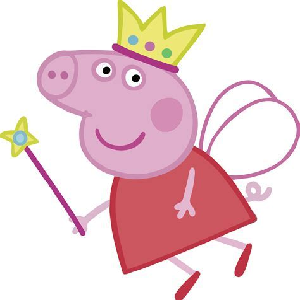

In [7]:
content_path = '../Images/pig2.jpg'
content_image=Image.open( content_path).resize((300,300))
content_image

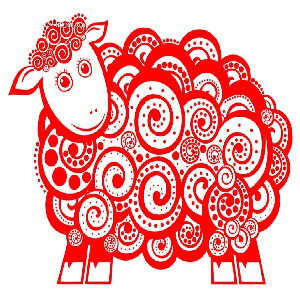

In [8]:
style_path = '../Images/style6.jpg'
style_image=Image.open(style_path).resize((300,300))
style_image

In [9]:
content_weight = 5.0
style_weight = 1.0
decay = 0.5
outer = 10
inner = 20
SIZE = [300,300]

SHIFT = np.reshape([103.939, 116.779, 123.68], (3, 1, 1)).astype('f')

def load_image(path):
    with Image.open(path) as pic:gbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbh mmmm
def save_image(img, path):
    sanitized_img = np.maximum(0, np.minimum(255, img+SHIFT))
    pic = Image.fromarray(np.uint8(np.transpose(sanitized_img, (1, 2, 0))))
    pic.save(path)


#顯示圖片
style=load_image(style_path)
content = load_image(content_path)
print(style.shape)
print(content.shape)

(3, 300, 300)
(3, 300, 300)


In [10]:
# 定義輸入與輸出
y = C.input_variable((3, SIZE[0],SIZE[1]), needs_gradient=True)
z, intermediate_layers = model(y, layers)


def ordered_outputs(f, binding):
    _, output_dict = f.forward(binding, f.outputs)
    return [np.squeeze(output_dict[out]) for out in f.outputs]


# 取得有被這兩張圖片活化的神經元
content_activations = ordered_outputs(intermediate_layers, {y: [[content]]})
style_activations = ordered_outputs(intermediate_layers, {y: [[style]]})
style_output = np.squeeze(z.eval({y: [[style]]}))

# 最後定義損失
n = len(content_activations)
total = (1-decay**(n+1))/(1-decay) 
loss = (1.0/total * content_weight * content_loss(y, content) 
         + 1.0/total * style_weight * style_loss(z, style_output) 
         + total_variation_loss(y))

for i in range(n):
    loss = (loss 
        + decay**(i+1)/total * (content_weight) * content_loss(intermediate_layers.outputs[i], content_activations[i])
        + decay**(n-i)/total * (style_weight)   *style_loss(intermediate_layers.outputs[i], style_activations[i]))

objective : 10515890.0
objective : 3769303.8
objective : 2888462.8
objective : 2512573.8
objective : 2351421.0
objective : 2245299.0
objective : 2166489.0
objective : 2115420.5
objective : 2045447.4
objective : 1997677.4


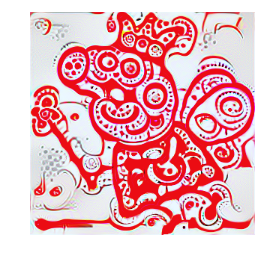

In [11]:
# 將向量轉為影像
import math
def vec2img(x):
    return np.reshape(x.astype(np.float32), (3,SIZE[0],SIZE[1]))

# 將影像轉為向量
def img2vec(img):
    return img.flatten().astype(np.float64)

#
def value_and_grads(f, binding):
    if len(f.outputs) != 1:
        raise ValueError('function must return a single tensor')
    df, valdict = f.forward(binding, [f.output], set([f.output]))
    value = list(valdict.values())[0]
    grads = f.backward(df, {f.output: np.ones_like(value)}, set(binding.keys()))
    return value, grads

# an objective function that scipy will be happy with
def objfun(x, loss):
    y = vec2img(x)
    v, g = value_and_grads(loss, {loss.arguments[0]: [[y]]})
    v = np.reshape(v, (1,))
    g = img2vec(list(g.values())[0])
    return v, g

# 最終最佳化函數
def optimize(loss, x0, inner, outer):
    bounds = [(-np.min(SHIFT), 255-np.max(SHIFT))]*x0.size
    for i in range(outer):
        s = opt.minimize(objfun, img2vec(x0), args=(loss,), method='L-BFGS-B', 
                         bounds=bounds, options={'maxiter': inner}, jac=True)
        print('objective : %s' % s.fun[0])
        x0 = vec2img(s.x)
        path = 'Results/pig_cntk_%d.jpg' % i
        save_image(x0, path)
    return x0


x0 = content
xstar = optimize(loss, x0, inner, outer)
plt.axis('off')
plt.imshow(np.asarray(np.transpose(xstar+SHIFT, (1, 2, 0)), dtype=np.uint8))